<img style="float: left;" src="earth-lab-logo-rgb.png" width="150" height="150" />

# Earth Analytics Education - Climate 101 Workshop

## <i class="fa fa-ship" aria-hidden="true"></i> NETCDF 4 Climate Data in Open Source Python 

In this lesson, you will learn how to work with Climate Data Sets (MACA v2 for the United states) stored in netcdf 4 format using open source **Python**.


## <i class="fa fa-graduation-cap" aria-hidden="true"></i> Learning Objectives

After completing this lesson, you will be able to:

* Download MACA v2 climate data in `netcdf 4` format
* Open and process netcdf4 data using `xarray`
* Export climate data in tabular format to `.csv` format


In [1]:
# Make sure ea dir exists - if not create it
# import os
# import earthpy as et
# #ea_path = os.path.join(et.io.HOME, 'earth-analytics', 'data')

# if not os.path.exists(ea_path):
#     os.makedirs(ea_path)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4
import xarray as xr
import rioxarray
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd
import earthpy as et

# Plotting options
sns.set(font_scale=1.3)
sns.set_style("white")

# Optional - set your working directory if you wish to use the data
# accessed lower down in this notebook (the USA state boundary data)
# os.chdir(os.path.join(et.io.HOME,
#                       'earth-analytics',
#                       'data'))

## Get Started wtih MACA Version 2 Data Using Open Source Python

In this lesson you will work with historic projected MACA 2 data that represents 
maximum monthly temperature for the Continental United States (CONUS). 
 
`agg_macav2metdata_tasmax_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_monthly`

The file name itself tells you a lot about the data. 

1. **macav2metdata**: the data are the MACA version two data which are downsampled to the extent of the continental United S tates
2. **tasmax**: Max temperature is the parameter contained within the data
3. **BNU-ESM**: This is the climate (CLM) model used to generate the data
4. **historical**: these data are the modeled historical values for the years **1950 - 2005**
5. **CONUS**: These data are for the **CON**tinental **U**nited **S**tates boundary
6. **monthly**: These data are aggregated monthly (rather than daily)

Below, you will learn how to open and work with MACA 2 data using open source Python tools. 
You will use the **xarray** package which requires the `netcdf4` package to work with netcdf data. 
The <a href="https://github.com/earthlab/earth-analytics-python-env" target="_blank">most current earth-analytics-python environment </a> contains all of the 
packages that you need to complete this tutorial.

To begin, you open up the data using `xarray.open_dataset`.

In [3]:
# The (online) url for the MACAv2 data - this won't work on binder but will work locally
#data_path = "http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_macav2metdata_tasmax_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_monthly.nc"

data_path = "macav2livneh_tasmax_BNU-ESM_r1i1p1_historical_1990_2005_CONUS_monthly.nc"

# Open the data using a context manager
with xr.open_dataset(data_path) as file_nc:
    max_temp_xr = file_nc

# View xarray object
max_temp_xr

<xarray.Dataset>
Dimensions:          (crs: 1, lat: 444, lon: 922, time: 192)
Coordinates:
  * lat              (lat) float64 25.16 25.22 25.28 25.34 ... 52.72 52.78 52.84
  * lon              (lon) float64 235.4 235.5 235.5 235.6 ... 292.8 292.9 293.0
  * time             (time) object 1990-01-15 00:00:00 ... 2005-12-15 00:00:00
  * crs              (crs) int32 1
Data variables:
    air_temperature  (time, lat, lon) float32 ...
Attributes:
    description:                     Multivariate Adaptive Constructed Analog...
    id:                              MACA-LIVNEH
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Metadata_Link:                   
    title:                           Downscaled daily meteorological data of ...
    summary:                         This archive contains downscaled meteoro...
    keywords:                        daily precipitation, daily maximum tempe...
    standard_name_vocabulary:        CF-1.0
    comment:                         Surface (10m) wind speed
    license:                         No restrictions
    geospatial_bounds:               POLYGON((-124.5938 25.1562,-124.5938 52....
    geospatial_lat_units:            decimal degrees north
    geospatial_lon_units:            decimal degrees east
    geospatial_vertical_min:         0.0
    geospatial_vertical_max:         0.0
    geospatial_vertical_resolution:  0.0
    geospatial_vertical_positive:    up
    time_coverage_start:             2086-01-01T00:0
    time_coverage_end:               2099-12-31T00:00
    time_coverage_duration:          P14Y
    time_coverage_resolution:        P1D
    date_created:                    2014-02-01
    date_issued:                     2014-02-01
    creator_name:                    John Abatzoglou
    creator_url:                     
    creator_email:                   jabatzoglou@uidaho.edu
    institution:                     University of Idaho
    processing_level:                Gridded Meteorological Projections
    contributor_name:                Katherine C. Hegewisch
    contributor_role:                Postdoctoral Fellow
    geospatial_lat_min:              25.1562
    geospatial_lat_max:              52.8438
    geospatial_lon_min:              -124.5938
    geospatial_lon_max:              -67.0312
    geospatial_lat_resolution:       0.0625
    geospatial_lon_resolution:       0.0625
    keywords_vocabulary:             
    project:                         Integrated Scenarios Project of the Nort...
    naming_authority:                edu.uidaho.nkn
    cdm_data_type:                   GRID
    publisher_name:                  Northwest Knowledge Network
    publisher_email:                 info@northwestknowledge.net
    publisher_url:                   http://www.northwestknowledge.net
    NCO:                             20150210
    history:                         Revision 2: Corrected the 5th decimal pl...
    date_modified:                   2015-02-13
    coordinate_system:               WGS84,EPSG:4326

By default `xarray` does not handle spatial operations. However, if you 
load `rioxarray` it adds additional spatial functionality (supported by 
`rasterio` that supports handling:

* coordinate reference systems
* reprojection
* clipping 

and more. Below you grab the `coordinate reference system` of the 
climate data using the `.rio.crs` method that is available
because you have rioxarray loaded in this notebook.

In [4]:
# For later - grab the crs of the data using rioxarray
climate_crs = max_temp_xr.rio.crs
climate_crs

CRS.from_wkt('GEOGCS["undefined",DATUM["undefined",SPHEROID["undefined",6378137,298.257223563]],PRIMEM["undefined",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]')

### Work With the NetCDF Data Structure - A Hierarchical Data Format

The object above is hierarchical and contains metadata making it self-describing.
There are three dimensions to consider when working with this data which represent the 
x,y and z dimensions of the data:

1. latitude
2. longitude
3. time 

The latitude and longitude dimension values reprensent an arrya containing the point location
value of each pixel in decimal degrees. These are location of each pixel in your data. The 
time array similarly represents the time location for each array in the data cube. 
This particular dataset contains historical modeleled monthly max temperature values for the 
Continental United States. 

In [5]:
# View first 5 latitude values
max_temp_xr["air_temperature"]["lat"].values[:5]

array([25.15625, 25.21875, 25.28125, 25.34375, 25.40625])

In [6]:
# View first 5 longitude values
max_temp_xr["air_temperature"]["lon"].values[:5]

array([235.40625, 235.46875, 235.53125, 235.59375, 235.65625])

In [7]:
# View first 5 and last. 5 time values - notice the span of
# dates range from 1950 to 2005
max_temp_xr["air_temperature"]["time"].values[:
                                              5], max_temp_xr["air_temperature"]["time"].values[-5:]

(array([cftime.DatetimeNoLeap(1990, 1, 15, 0, 0, 0, 0),
        cftime.DatetimeNoLeap(1990, 2, 15, 0, 0, 0, 0),
        cftime.DatetimeNoLeap(1990, 3, 15, 0, 0, 0, 0),
        cftime.DatetimeNoLeap(1990, 4, 15, 0, 0, 0, 0),
        cftime.DatetimeNoLeap(1990, 5, 15, 0, 0, 0, 0)], dtype=object),
 array([cftime.DatetimeNoLeap(2005, 8, 15, 0, 0, 0, 0),
        cftime.DatetimeNoLeap(2005, 9, 15, 0, 0, 0, 0),
        cftime.DatetimeNoLeap(2005, 10, 15, 0, 0, 0, 0),
        cftime.DatetimeNoLeap(2005, 11, 15, 0, 0, 0, 0),
        cftime.DatetimeNoLeap(2005, 12, 15, 0, 0, 0, 0)], dtype=object))

In [8]:
max_temp_xr["air_temperature"]["time"].values.shape

(192,)

Time is the z dimension. In this dataset you have 
672 months worth of data.

These data are spatial and thus have a coordinate reference system
associated with them. You can access this information using `.crs` 

HINT `max_temp_xr["crs"]` should also work!

In [9]:
# The data are lat/long (not projected)
max_temp_xr.crs

<xarray.DataArray 'crs' (crs: 1)>
array([1], dtype=int32)
Coordinates:
  * crs      (crs) int32 1
Attributes:
    grid_mapping_name:            latitude_longitude
    longitude_of_prime_meridian:  0.0
    semi_major_axis:              6378137.0
    inverse_flattening:           298.257223563

## Hierarchical Formats Are Self Describing

Hierarchical data formats are self-describing. This means that the 
metadata for the data are contained within the file itself. `xarray` 
stores metadata in the `.attrs` part of the file structure using a 
Python dictionary structure. You can view the metadata using `.attrs`.

In [10]:
# View metadata
metadata = max_temp_xr.attrs
metadata

{'description': 'Multivariate Adaptive Constructed Analogs (MACA) method, version 2.3,Dec 2013.',
 'id': 'MACA-LIVNEH',
 'Metadata_Conventions': 'Unidata Dataset Discovery v1.0',
 'Metadata_Link': '',
 'title': 'Downscaled daily meteorological data of Daily Mean Near-Surface Wind Speed from Institute for Numerical Mathematics (inmcm4) using the run r1i1p1 of the rcp85 scenario.',
 'summary': 'This archive contains downscaled meteorological and hydrological projections for the Conterminous United States at 1/16-deg resolution utilizing the Multivariate Adaptive Constructed Analogs (MACA, Abatzoglou, 2012) statistical downscaling method with the Livneh et al (2013) training dataset. The downscaled meteorological variables are maximum/minimum temperature(tasmax/tasmin), precipitation amount(pr), downward shortwave solar radiation(rsds), wind speed(was), and specific humidity(huss). The downscaling is based on the 365-day model outputs from different global climate models (GCMs) from Phase

In [11]:
# Above you grabbed the metadata (which is a dictionary)
# Here you can print any part of the dictionary that you wish to
metadata["title"]

'Downscaled daily meteorological data of Daily Mean Near-Surface Wind Speed from Institute for Numerical Mathematics (inmcm4) using the run r1i1p1 of the rcp85 scenario.'

## Subsetting or "Slicing" Your Data
 
You can quickly and efficiently slice and subset your data using 
`xarray`. Below, you will learn how to slice the data using the `.sel()` method.

This will return exactly two data points at the location - the temperature 
value for each day in your temporal slice.

In [12]:
# Select a lat / lon location that you wish to use to extract the data
latitude = max_temp_xr.lat[300].values
longitude = max_temp_xr.lon[300].values
print("You selected the following x,y location:", longitude, latitude)

You selected the following x,y location: 254.15625 43.90625000000001


Below, you can see the x, y location that for the latitude/longitude
location that you will use to slice the data above plotted on a map. 
The code below is an example of creating a spatial plot using
the `cartopy` package that shows the locatio nthat you selected. **This step is optional.**

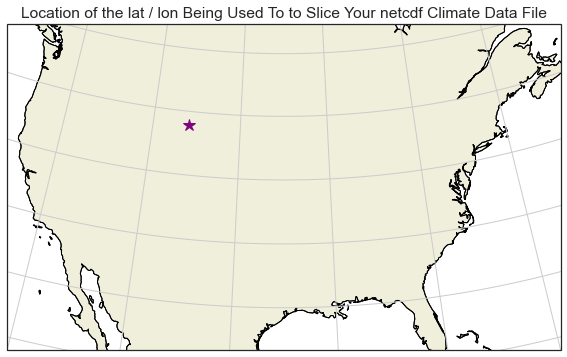

In [13]:
central_lat = 37.5
central_lon = -96
extent = [-120, -70, 24, 50.5]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

f, ax = plt.subplots(figsize=(12, 6),
                     subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)})
ax.coastlines()
ax.plot(longitude, latitude,
        markersize=12,
        marker='*',
        color='purple',
       transform=ccrs.PlateCarree())
ax.set_extent(extent)
ax.set(title="Location of the lat / lon Being Used To to Slice Your netcdf Climate Data File")

# Adds a bunch of elements to the map
ax.add_feature(cfeature.LAND, edgecolor='black')

ax.gridlines()
plt.show()

Now it is time to subset the data for the point location that 
you are interested in (the lat / lon value that you plotted above). 
You can slice the data for one single latitude, longitude location using
the `.sel()` method.

When you slice the data using one single point, your output for every 
(monthly in this case) time step in the data will be a single pixel 
value representing max temperature. 

In [14]:
# Slice the data spatially using a single lat/lon point
one_point = max_temp_xr["air_temperature"].sel(lat=latitude,
                                               lon=longitude)
one_point

<xarray.DataArray 'air_temperature' (time: 192)>
array([276.4903 , 275.28986, 278.21396, 283.95285, 292.1909 , 296.9716 ,
       301.7781 , 301.45853, 295.46143, 293.307  , 279.92792, 271.4658 ,
       280.31375, 272.6027 , 280.58493, 287.32877, 293.55682, 297.00208,
       304.19107, 300.8949 , 294.15326, 289.3812 , 282.1746 , 274.9137 ,
       277.38815, 279.93423, 279.6834 , 282.04852, 294.1635 , 298.36813,
       300.06915, 303.78445, 292.66718, 287.62335, 275.48877, 273.88693,
       276.0564 , 276.39517, 284.89905, 282.45633, 288.49142, 293.9815 ,
       300.969  , 300.65494, 296.64804, 283.54242, 274.92682, 273.41937,
       271.09433, 273.90402, 281.96405, 286.8665 , 293.79532, 301.30637,
       302.45258, 304.23117, 298.82892, 289.51678, 277.5233 , 266.6537 ,
       276.03934, 278.5808 , 282.46384, 285.09082, 290.11914, 296.47736,
       304.46017, 304.5209 , 293.0272 , 290.252  , 284.09454, 275.10083,
       269.28992, 273.47308, 277.03995, 279.71268, 290.3758 , 291.60587,
       301.23804, 303.58282, 295.35675, 290.91928, 281.446  , 274.16306,
       273.60162, 280.38657, 278.33237, 278.6455 , 285.14603, 293.80676,
       302.51917, 301.89185, 294.2023 , 286.62375, 282.7112 , 277.84   ,
       279.60117, 272.17352, 279.52078, 289.49954, 289.85773, 301.68094,
       304.34766, 304.1632 , 296.7697 , 291.95242, 280.36414, 272.99313,
       271.53568, 284.92392, 277.7717 , 287.16113, 292.24597, 296.00375,
       305.01413, 303.58026, 297.0292 , 290.25778, 280.51028, 273.06732,
       272.99283, 273.5279 , 281.75485, 281.86728, 295.06192, 297.06943,
       302.45505, 302.9985 , 297.3467 , 291.28735, 274.9517 , 272.71942,
       273.17386, 278.65442, 282.13715, 288.97525, 296.7481 , 299.9621 ,
       302.68942, 301.38495, 298.74124, 291.8499 , 276.63364, 278.21722,
       281.45828, 273.821  , 287.73517, 293.6915 , 292.99768, 301.0256 ,
       305.63126, 304.15594, 293.87094, 288.71112, 278.58572, 276.36804,
       272.3733 , 273.16714, 284.44177, 287.6084 , 296.05096, 296.42133,
       303.49112, 301.65012, 298.89276, 291.8448 , 280.84607, 273.0541 ,
       271.19418, 276.39883, 279.0086 , 287.22003, 291.47598, 300.76752,
       306.49088, 302.30173, 293.69028, 292.65762, 279.2499 , 280.5174 ,
       273.77438, 275.6525 , 278.02576, 284.24374, 289.1075 , 298.66467,
       302.91367, 302.84644, 293.12317, 287.0908 , 281.64218, 271.59525],
      dtype=float32)
Coordinates:
    lat      float64 43.91
    lon      float64 254.2
  * time     (time) object 1990-01-15 00:00:00 ... 2005-12-15 00:00:00
Attributes:
    long_name:      Monthly Average of Daily Maximum Near-Surface Air Tempera...
    units:          K
    grid_mapping:   crs
    standard_name:  air_temperature
    height:         2 m
    cell_methods:   time: maximum(interval: 24 hours);mean over days

When you slice the data by a single point, notice that output data
only has a single array of values. In this case these values represent
air temperature (in K) over time. 

In [15]:
# Notice the shape of the output array
one_point.shape

(192,)

The data stored in the xarray object is a numpy array. You can process
the data in the same way you would process any other numpy array.  

In [16]:
# View the first 5 values for that single point
one_point.values[:5]

array([276.4903 , 275.28986, 278.21396, 283.95285, 292.1909 ],
      dtype=float32)

### Plot A Time Series For a Single Location 

Above you used a single point location to slice your data. Because
the data are for only one location, but over time, you can quickly 
create a scatterplot of the data using `objectname.plot()`.


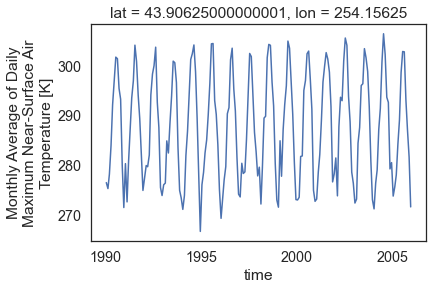

In [17]:
# Use xarray to create a quick time series plot
one_point.plot.line()
plt.show()

You can make the plot a bit prettier if you'd like using the 
standard Python matplotlib plot parameters. Below you change the marker color 
to purple and the lines to grey. `figsize` is used to adjust the 
size of the plot. 

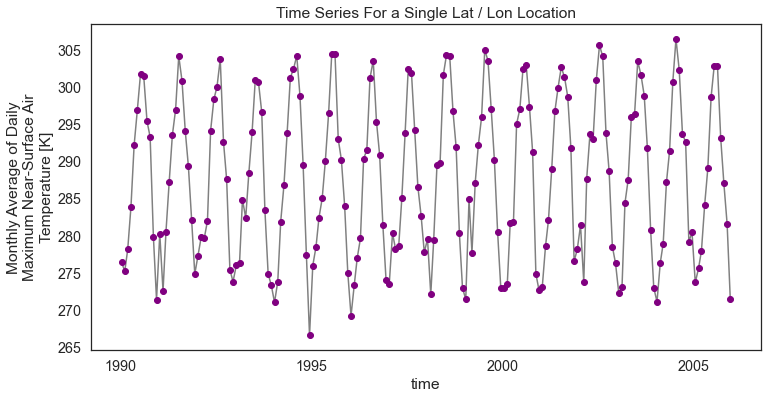

In [18]:
# You can clean up your plot as you wish using standard matplotlib approaches
f, ax = plt.subplots(figsize=(12, 6))
one_point.plot.line(hue='lat',
                    marker="o",
                    ax=ax,
                    color="grey",
                    markerfacecolor="purple",
                    markeredgecolor="purple")
ax.set(title="Time Series For a Single Lat / Lon Location")

# Uncomment the line below if you wish to export the figure as a .png file
# plt.savefig("single_point_timeseries.png")
plt.show()

### Convert Climate Time Series Data to a Pandas DataFrame & Export to a .csv File
You can convert your data to a `DataFrame` and export to 
a `.csv` file using `to_dataframe()` and `to_csv()`. 

In [19]:
# Convert to dataframe -- then this can easily be exported to a csv
one_point_df = one_point.to_dataframe()
# View just the first 5 rows of the data
one_point_df.head()

,lat,lon,air_temperature
time,,,
1990-01-15 00:00:00,43.90625,254.15625,276.490295
1990-02-15 00:00:00,43.90625,254.15625,275.289856
1990-03-15 00:00:00,43.90625,254.15625,278.213959
1990-04-15 00:00:00,43.90625,254.15625,283.952850
1990-05-15 00:00:00,43.90625,254.15625,292.190887


Once you have a dataframe object, you can export it
directly to a `.csv` file format.

In [20]:
# Export data to .csv file
one_point_df.to_csv("one-location.csv")

## Slice Climate MACAv2 Data By Time and Location

Above you sliced the data by spatial location, selecting only one point
location at a specific latitude and longitude. You can also slice the data by time. 
Below, you slice the data at the selected lat / long location and for a 5-year time period
in the year 2000.

Notice that the output shape is 60. 60 represents 12 months a year over 5 years
for the selected lat / lon location. Again because you are slicing out data 
for a single point location, you have a total of 60 data points in the output
numpy array.

In [21]:
start_date = "2000-01-01"
end_date = "2005-01-01"
temp_2000_2005 = max_temp_xr["air_temperature"].sel(time=slice(start_date, end_date),
                                                    lat=latitude,
                                                    lon=longitude)
temp_2000_2005

<xarray.DataArray 'air_temperature' (time: 60)>
array([272.99283, 273.5279 , 281.75485, 281.86728, 295.06192, 297.06943,
       302.45505, 302.9985 , 297.3467 , 291.28735, 274.9517 , 272.71942,
       273.17386, 278.65442, 282.13715, 288.97525, 296.7481 , 299.9621 ,
       302.68942, 301.38495, 298.74124, 291.8499 , 276.63364, 278.21722,
       281.45828, 273.821  , 287.73517, 293.6915 , 292.99768, 301.0256 ,
       305.63126, 304.15594, 293.87094, 288.71112, 278.58572, 276.36804,
       272.3733 , 273.16714, 284.44177, 287.6084 , 296.05096, 296.42133,
       303.49112, 301.65012, 298.89276, 291.8448 , 280.84607, 273.0541 ,
       271.19418, 276.39883, 279.0086 , 287.22003, 291.47598, 300.76752,
       306.49088, 302.30173, 293.69028, 292.65762, 279.2499 , 280.5174 ],
      dtype=float32)
Coordinates:
    lat      float64 43.91
    lon      float64 254.2
  * time     (time) object 2000-01-15 00:00:00 ... 2004-12-15 00:00:00
Attributes:
    long_name:      Monthly Average of Daily Maximum Near-Surface Air Tempera...
    units:          K
    grid_mapping:   crs
    standard_name:  air_temperature
    height:         2 m
    cell_methods:   time: maximum(interval: 24 hours);mean over days

In [22]:
temp_2000_2005.shape

(60,)

In [23]:
# View the 60 data points (raster cell values) associated with the spatial and temporal subset
temp_2000_2005.values

array([272.99283, 273.5279 , 281.75485, 281.86728, 295.06192, 297.06943,
       302.45505, 302.9985 , 297.3467 , 291.28735, 274.9517 , 272.71942,
       273.17386, 278.65442, 282.13715, 288.97525, 296.7481 , 299.9621 ,
       302.68942, 301.38495, 298.74124, 291.8499 , 276.63364, 278.21722,
       281.45828, 273.821  , 287.73517, 293.6915 , 292.99768, 301.0256 ,
       305.63126, 304.15594, 293.87094, 288.71112, 278.58572, 276.36804,
       272.3733 , 273.16714, 284.44177, 287.6084 , 296.05096, 296.42133,
       303.49112, 301.65012, 298.89276, 291.8448 , 280.84607, 273.0541 ,
       271.19418, 276.39883, 279.0086 , 287.22003, 291.47598, 300.76752,
       306.49088, 302.30173, 293.69028, 292.65762, 279.2499 , 280.5174 ],
      dtype=float32)

Notice that in this instance you have much less data for that specific point
(5 years worth of data to be exact).

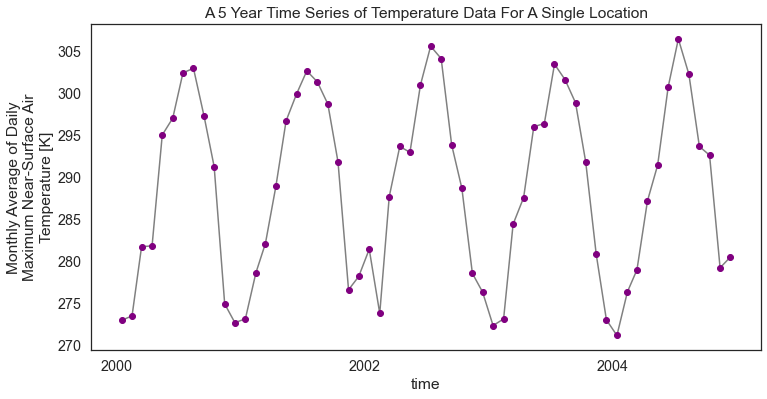

In [24]:
# Plot the data just like you did above
f, ax = plt.subplots(figsize=(12, 6))
temp_2000_2005.plot.line(hue='lat',
                         marker="o",
                         ax=ax,
                         color="grey",
                         markerfacecolor="purple",
                         markeredgecolor="purple")
ax.set(title="A 5 Year Time Series of Temperature Data For A Single Location")
plt.show()

## Convert Subsetted to a DataFrame & Export to a .csv File

Similar to what you did above, you can also convert your data to a DataFrame. Once your data are in a 
DataFrame format, you can quickly export a `.csv` file.

In [25]:
# Convert to dataframe -- then this can be exported to a csv if you want that
temp_2000_2005_df = temp_2000_2005.to_dataframe()
# View just the first 5 rows of the data
temp_2000_2005_df.head()

,lat,lon,air_temperature
time,,,
2000-01-15 00:00:00,43.90625,254.15625,272.992828
2000-02-15 00:00:00,43.90625,254.15625,273.527893
2000-03-15 00:00:00,43.90625,254.15625,281.754852
2000-04-15 00:00:00,43.90625,254.15625,281.867279
2000-05-15 00:00:00,43.90625,254.15625,295.061920


In [26]:
# Create filename from subset info
file_name = "monthly-temp-" + start_date + "-" + end_date + ".csv"
file_name

'monthly-temp-2000-01-01-2005-01-01.csv'

In [27]:
# Export to a csv file to share with your friends!
temp_2000_2005_df.to_csv(file_name)

## Slice The Data Across a Spatial Extent For A Specific Time Period

In the above example you sliced out a subset of the data for a specific
point location over time. Below you select 
data for the entire CONUS (Continental United States) study area and analyze it 
as a spatial raster object.

Once again you use `.sel()` combined with `slice()` subset the data. 

Notice below that if you don't specify the lat and lon extent, 
it will by default return all of the pixels available in the data for the 
specified time period.

Notice that you are plotting the entire spatial extent of the data which is 
in this case called CONUS (**CON**tinental **U**nited **S**tates)

In [28]:
start_date = "1990-01-15"
end_date = "1990-02-15"

two_months_conus = max_temp_xr["air_temperature"].sel(
    time=slice(start_date, end_date))
# Notice that time has a value of **2** below representing two time steps or months worth of data
two_months_conus

<xarray.DataArray 'air_temperature' (time: 2, lat: 444, lon: 922)>
[818736 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 25.16 25.22 25.28 25.34 ... 52.66 52.72 52.78 52.84
  * lon      (lon) float64 235.4 235.5 235.5 235.6 ... 292.8 292.8 292.9 293.0
  * time     (time) object 1990-01-15 00:00:00 1990-02-15 00:00:00
Attributes:
    long_name:      Monthly Average of Daily Maximum Near-Surface Air Tempera...
    units:          K
    grid_mapping:   crs
    standard_name:  air_temperature
    height:         2 m
    cell_methods:   time: maximum(interval: 24 hours);mean over days

In [29]:
two_months_conus.shape

(2, 444, 922)

The default return when you plot an xarray object with multipple years worth of 
data across a spatial extent is a histogram.

In [30]:
two_months_conus.shape

(2, 444, 922)

When you call `.plot()` on the data, the default plot is a 
histogram representing the range of raster pixel values in your data 
for all time periods (2 months in this case). 

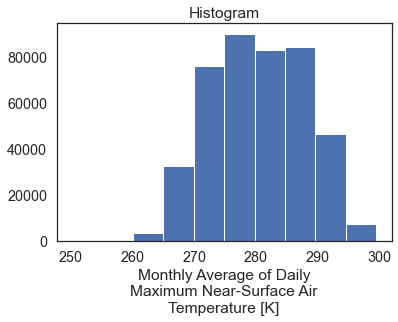

In [31]:
# Directly plot just a single day using time in "years"
two_months_conus.plot()
plt.show()

## Spatial Raster Plots of MACA v2 Climate Data
If you want to plot the data spatially as a raster, you can use 
`.plot()` but specify the lon and lat values as the x and y dimensions 
to plot. You can add the following parameters to your `.plot()` call to 
make sure each time step in your data plots spatially:

`col_wrap=2`: adjust how how many columns the each subplot is spread across
`col=`: what dimension is being plotted in each subplot.

In this case, you want a single raster for each month (time step) in the 
data so you specify `col='time'`. `col_wrap=1` forces the plots to 
stack on top of each other in your `matplotlib` figure. 

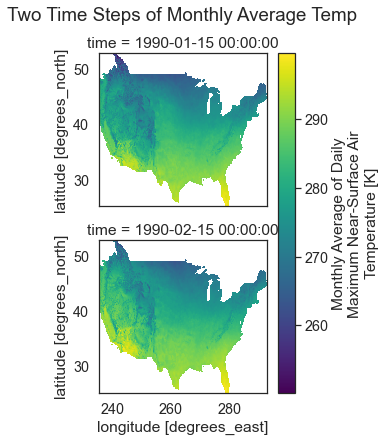

In [32]:
# Quickly plot the data using xarray.plot()
two_months_conus.plot(x="lon",
                      y="lat",
                      col="time",
                      col_wrap=1)
plt.suptitle("Two Time Steps of Monthly Average Temp", y=1.03)
plt.show()

If you set `col_wrap` to `2` you end up with two columns and
one subplot in each column. 

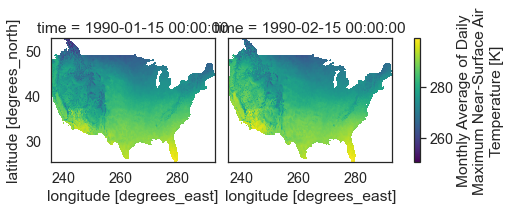

In [33]:
# Plot the data using 2 columns
two_months_conus.plot(x="lon",
                      y="lat",
                      col="time",
                      col_wrap=2)
plt.show()

In [34]:
# https://scitools.org.uk/cartopy/docs/latest/crs/projections.html

## Plot Multiple MACA v2 Climate Data Raster Files With a Spatial Projection

Below you plot the same data using `cartopy` which support spatial 
projectsion. The `coastlines()` basemap is also added to the plot. 

/Users/leahwasser/opt/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


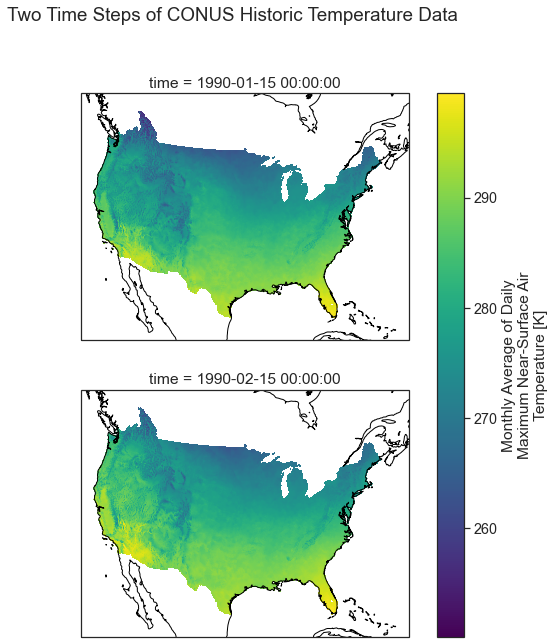

In [35]:
central_lat = 37.5
central_long = 96
extent = [-120, -70, 20, 55.5]  # CONUS

map_proj = ccrs.AlbersEqualArea(central_longitude=central_lon,
                                central_latitude=central_lat)

aspect = two_months_conus.shape[2] / two_months_conus.shape[1]
p = two_months_conus.plot(transform=ccrs.PlateCarree(),  # the data's projection
                          col='time', col_wrap=1,
                          aspect=aspect,
                          figsize=(10, 10),
                          subplot_kws={'projection': map_proj})  # the plot's projection

plt.suptitle("Two Time Steps of CONUS Historic Temperature Data", y=1)
# Add the coastlines to each axis object and set extent
for ax in p.axes.flat:
    ax.coastlines()
    ax.set_extent(extent)

## Export Raster to Geotiff File 

In the above workflows you converted your data into a DataFrame and exported
it to a .csv file. This approach works well if you only need the summary values
and don't need any spatial information. However sometimes you may need to 
export spatial raster files.

You can export your data to a geotiff file format using rioxarray. 
To do this you will need to:

1. ensure that your xarray object has a crs defined and define it if it's missing.
2. call xarray to export your data

Notice below that your two month subset no long contains CRS information.


In [36]:
# The data no longer have a crs -
two_months_conus.rio.crs

At the very beginning of this lesson, you saved the crs information 
from the original xarray object. You can use that to export your geotiff data
below.

In [37]:
# Set the crs of your subsetted xarray object
two_months_conus.rio.set_crs(climate_crs)
two_months_conus.rio.crs

CRS.from_wkt('GEOGCS["undefined",DATUM["undefined",SPHEROID["undefined",6378137,298.257223563]],PRIMEM["undefined",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]')

Once the crs is set, you can export to a geotiff file format.

In [38]:
# Export to geotiff
two_months_conus.rio.to_raster('test.tif')

Now test our your data. Reimport it using `xarray.open_rasterio`.

In [39]:
# Open the data up as a geotiff
two_months_tiff = xr.open_rasterio('test.tif')
two_months_tiff

<xarray.DataArray (band: 2, y: 444, x: 922)>
[818736 values with dtype=float32]
Coordinates:
  * band     (band) int64 1 2
  * y        (y) float64 25.16 25.22 25.28 25.34 ... 52.66 52.72 52.78 52.84
  * x        (x) float64 235.4 235.5 235.5 235.6 ... 292.8 292.8 292.9 293.0
Attributes:
    transform:      (0.0625, 0.0, 235.375, 0.0, 0.06250000000000001, 25.12500...
    crs:            +proj=longlat +ellps=WGS84 +no_defs=True
    res:            (0.0625, -0.06250000000000001)
    is_tiled:       0
    nodatavals:     (-9999.0, -9999.0)
    scales:         (1.0, 1.0)
    offsets:        (0.0, 0.0)
    descriptions:   ('Monthly Average of Daily Maximum Near-Surface Air Tempe...
    AREA_OR_POINT:  Area
    cell_methods:   time: maximum(interval: 24 hours);mean over days
    grid_mapping:   crs
    height:         2 m
    long_name:      Monthly Average of Daily Maximum Near-Surface Air Tempera...
    standard_name:  air_temperature
    units:          K

Plot the data. Do you notice anything about the values 
in the histogram below?

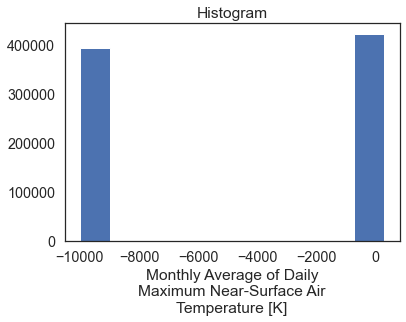

In [40]:
two_months_tiff.plot()
plt.show()

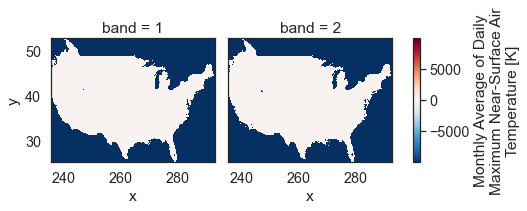

In [41]:
# Plot the data - this doesn't look right!
two_months_tiff.plot(col="band")
plt.show()

The data above are plotting oddly because there are no data 
values in your array. You can mask those values using `xarray.where()`.

In [42]:
two_months_tiff.rio.nodata

-9999.0

Below you use `.where()` to mask all values in your data that are 
equal to `-9999`, the nodata value for this data.

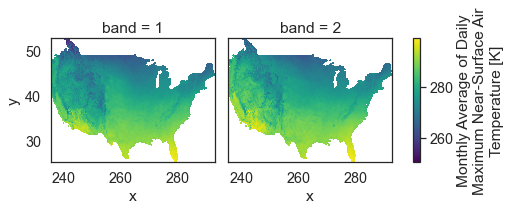

In [43]:
# Remove no data values and try to plot again
two_months_tiff = xr.open_rasterio('test.tif')
two_months_clean = two_months_tiff.where(
    two_months_tiff != two_months_tiff.rio.nodata)

two_months_clean.plot(col="band")
plt.show()

Above you learned how to begin to work with NETCDF4 format files containing 
climate focused data. You learned how to open and subset the data by time and location.
In the next lesson you will learn how to implement more complex spatial subsets of your data.